# Housing Prices
## 1. BigPicture
### Objective
To predict the prices of a district. The model oput will fed another ML model to determine if it is worth investing in that district.

### Current state
The district housing prices are determined manually by experts.

### Problem caracteristics 
- Supervised learning task (labeled examples)
- Regression task (need to predict a value)
- Batch learning task (fixed dataset)

### Performance measure
- RMSE

## 2. Get the data
Esto suele implicar mucho más problema que esto que sigue aca abajo dnd ya esta todo procesado y tal.

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


El dataset consiste en 10 columnas. No está explícito pero `longitud` y `latitude` son primary keys.  
Parece que hay máximo 20640 instancias de housing prices. La única que hay menos es `total_bedrooms`  
Todas las variables parecen ser entre float e int, salvo `ocean_proximity` que es categórica.  


In [5]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

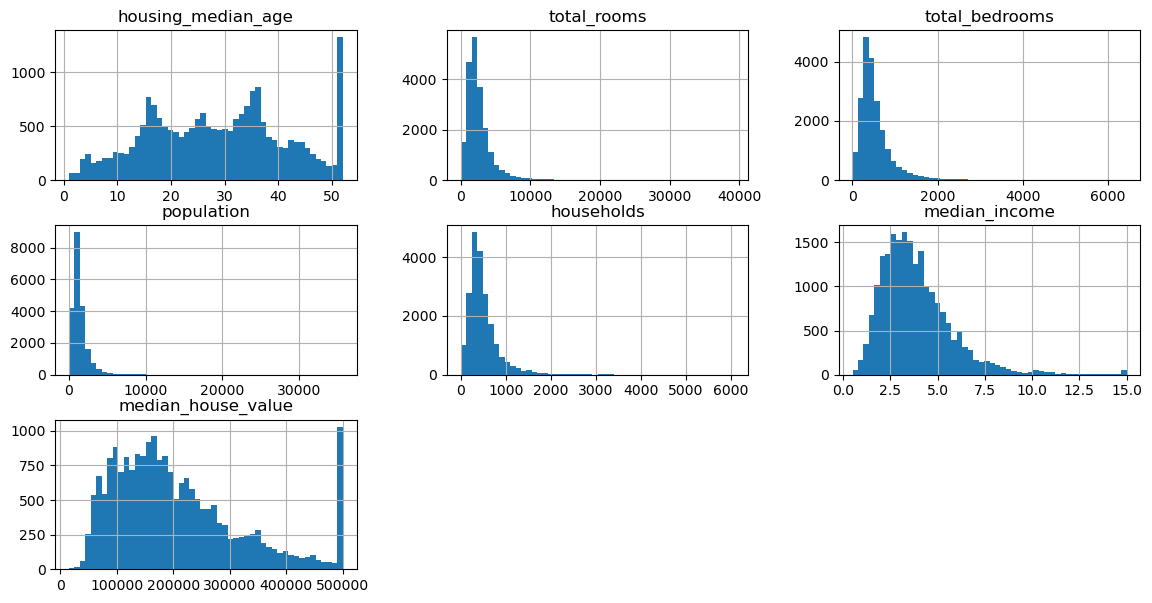

In [6]:
import matplotlib.pyplot as plt
housing.drop(columns=['latitude', 'longitude']).hist(figsize=(14,7), bins=50)
plt.show()

Acá hay un par de cosas a tener en cuenta:
1. La edad de las propiedades llega hasta 52 máximo. Es decir si alguna tiene 56, se marca como 52. 
2. `total_rooms` y `total_bedrooms` debe ser la cantidad de metros cuadrados de las habitaciones porque si no se explica que haya de hasta ~40000
3. `median_income` esta normalizado por 10 mil dolares. 
4. `median_house_value` también está capeado hasta 500001. Esto es un problema porque es lo que justamente quiero predecir. 
5. Otro punto imporatnte es que están todos skewed right. Esto es medio choto para los algoritmos. 

### Create a test set
Esto lo podemos hacer con un *random sampling* o con un *stratified sampling*.

Vamos a armar un stratified sampling con `median_income`, es decir, manteniendo las proporciones de este campo en el train y test. 
Primero, como el histograma de `median_income` está bastante skewed, vamos a generar un nuevo *feature* que se llame `income_cat`, que le asigna `1` al `median_income` entre 0 y 1.5, 2 entre 1.5 y 3 y así...  
Demás está decir que esta clasificación es bastante arbitraria. Surge de mirar el histograma de antes. 

<Axes: >

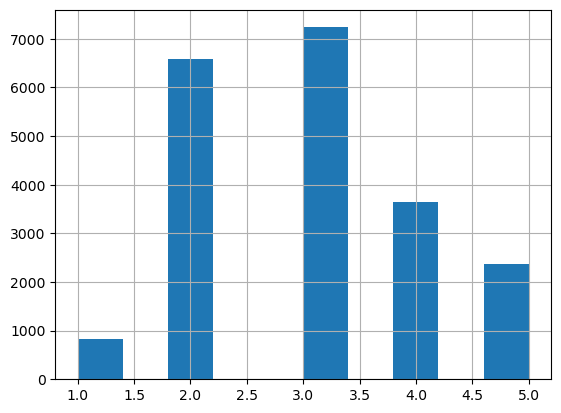

In [7]:
import numpy as np 
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

En `sklearn.model_selection` hay muchas clases de *splitters*, que tienen cada uno un método `split()`.  
Estos métodos te devuelven los índices de la separación, de forma que vos puedas armar el split que quieras para después cross-validar.  

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# Por ahora me quedo con el primer split:


In [9]:
strat_train_set, strat_test_set = strat_splits[0]
print(f"strat_train_set shape: {strat_train_set.shape}")
print(f"strat_trest_set shape: {strat_test_set.shape}")

strat_train_set shape: (16512, 11)
strat_trest_set shape: (4128, 11)


In [10]:
# Esto mismo se podía hacer de esta forma:
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [11]:
# Tiramos a la mierda esta categoría inventada ahora que ya armamos la estratificación
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 3. Explore and visualize

<Axes: xlabel='longitude', ylabel='latitude'>

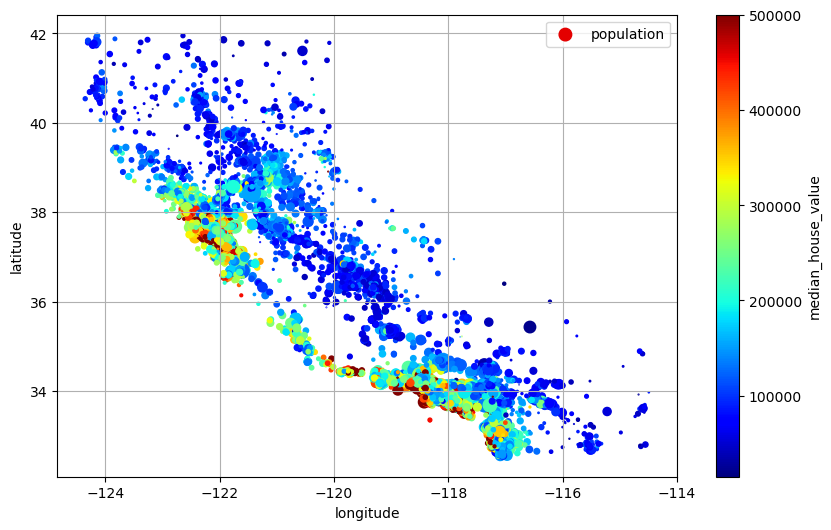

In [12]:
housing = strat_train_set.copy()

housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    s=housing["population"] / 100,
    label='population',
    c='median_house_value',
    cmap='jet',
    colorbar=True,
    legend=True,
    figsize=(10,6),
    sharex=False,
)

### Look for correlations

In [13]:
corr_matrix = housing.corr(numeric_only=True)

In [14]:
# A ver a qué se correlaciona lo que yo estoy queriendo modelar
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Se correlaciona más que nada con el `median_income`. Veamos

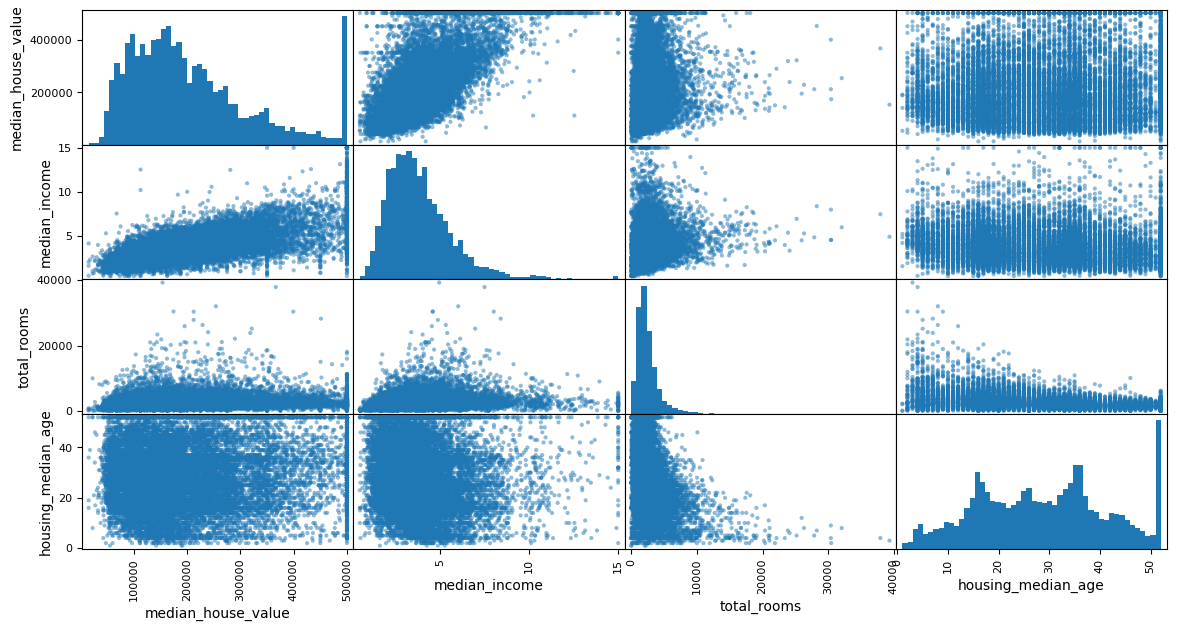

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
_ = scatter_matrix(housing[attributes], figsize=(14, 7), hist_kwds={'bins':50})

<Axes: xlabel='median_income', ylabel='median_house_value'>

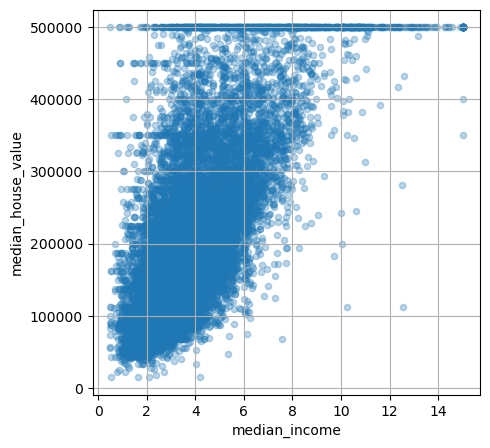

In [16]:
housing.plot(
    kind="scatter",
    x="median_income",
    y="median_house_value",
    figsize=(5, 5),
    grid=True,
    alpha=0.3,
)

### Experimenting with attributes combinations

1. `total_rooms` solo no me dice nada pero si lo normalizo por la cantidad de `households` sí
2. Lo mismo `total_bedrooms`y `total_rooms`
3. Lo mismo `population` y `households`

In [17]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

A ver ahora como se correlacionan las nuevas mierdas

In [18]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

Y ahora vemos que `rooms_per_house` se correlaciona más con la variable de interés que `total_rooms`, aunque no aumenta mucho. Además hay una correlación negativa bastante fuerte con `bedrooms_ratio`, es decir, mientras menor es la cantidad de bedrooms per room, más guita sale la casa.  

## 4. Prepare the Data for ML Algorithms

In [19]:
# Primero vuelvo a empezar de 0.
# Ahora separo en predictors y target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Clean the Data

El campo `total_bedrooms` tenia datos faltantes, por lo que podemos hacer 3 cosas:
1. Tirar esos datos
2. Tirar toda la columna
3. Imputar (rellenar) con la media, la mediana, o a algo

Hacemos esto último

In [22]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
# Solo puedo imputar esto los atributos numericos
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
# el imputer ahroa le calculo la mediana a todas las columnas
imputer.statistics_
# Así que ahora va a rellenar con estos datos si hay un NaN
X = imputer.transform(housing_num)

Otros imputers copados:  

`KNNImputer`: replaces each missing value with the mean of the *k*-nearest neighbors' values for that feature. The distance is based on all the available features.  
`IterativeImputer`: trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

In [25]:
# Recupero housing

housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

### Handling text and categorical attributes
Tenemos que encodear estos string de `ocean_proximity`

In [27]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
housing_cat_encoded = encoder.fit_transform(housing[["ocean_proximity"]])
housing_cat_encoded[:5]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.]])

El problema con esto es que el algoritmo de ML puede asumir que hay una relación numérica de orden entre las categorías. Si fuera una categoría pseudo-cuantitativa estaría bien (onda "bar", "avergage" and "good"). 
Para este caso vamos a usar el *one-hot encoding*, que lo que va a hacer es ampliarme la matrix del DataFrame para tener atributos que sean las categorías de `ocean_proximity`.

In [28]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_onehot = encoder.fit_transform(housing[['ocean_proximity']])
housing_onehot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [35]:
# Lo pasamos a DataFrame
housing_cat_encoded = pd.DataFrame(
    housing_onehot.toarray(),
    columns=encoder.get_feature_names_out(),
    index=housing.index
)
housing_cat_encoded.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0


### Feature Scaling and Transformation
Vamos a normalizar todos los campos. 

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
housing_num_scaled = scaler.fit_transform(housing_num)

Cuando tenemos features que tienen una cola muy pronunciada, a veces conviene transformarlos con el logaritmo, para que queden más bell-shaped

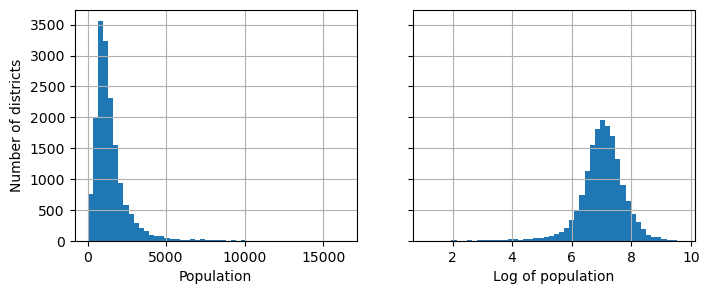

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
# save_fig("long_tail_plot")
plt.show()

Otra que está buena es bucketizar los datos, reemplazando cada valor por buckets que sean del mismo tamaño aprox. Por ejemplo, podemos reemplazar cada valor por su percentil. De esta manera nos queda algo que tiene distribución uniforme

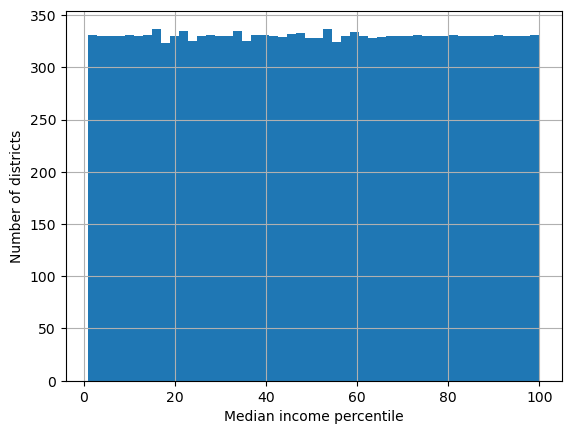

In [38]:
percentiles = [np.percentile(housing["median_income"], p)
               for p in range(1, 100)]
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf],
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=50)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()

In [41]:
flattened_median_income

13096    14
14973    90
3785     22
14689    18
20507    50
         ..
14207    75
13105    26
19301    63
19121    65
19888    45
Name: median_income, Length: 16512, dtype: category
Categories (100, int64): [1 < 2 < 3 < 4 ... 97 < 98 < 99 < 100]

Entonces por ejemplo, aca el valor de cada `housing_median_income` se reemplaza por su percentil. Si divido por la cantidad de bins que hago, me quedará de 0 a 1. 

Algo que sirve para features con distribuciones multimodal añadir un feature por cada modo, que represente la *similarity* entre la caracteristica en cuestión y la moda. Se suele utilizar funciones *radial basis function*, que depende de la distancia entre el valor deseado y *x*: 

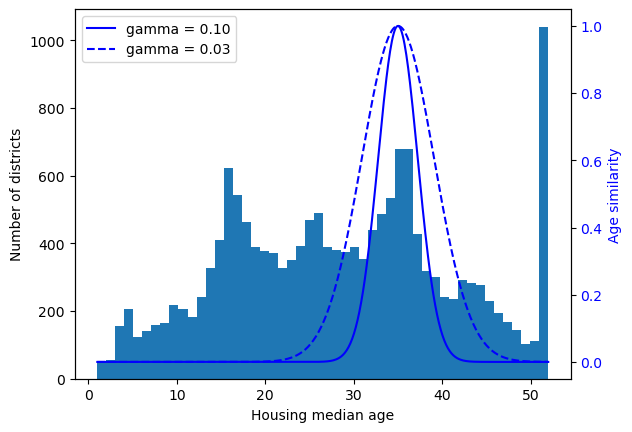

In [43]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
# extra code – this cell generates Figure 2–18

ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
# save_fig("age_similarity_plot")
plt.show()

Entonces, si este grupo particular de edades de la casas esta bien correlacionado con los precios bajo, hay unas buenas chances de que este nuevo feature ayude al modelo. 